<a href="https://colab.research.google.com/github/DanielTzafrir/Final-Project/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pydub

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Create wav files from raw data

In [ ]:
import pandas as pd

# Read CSV file
df = pd.read_csv('Raw data.csv')

# Extract time and sound intensity columns
time = df['Time (s)'].values
intensity = df['Recording (a.u.)'].values


In [ ]:
import numpy as np
from scipy.interpolate import interp1d

# Interpolate data if needed
interp_func = interp1d(time, intensity, kind='linear')

# Define the time range for the waveform
sample_rate = 16000  # Example sample rate (adjust as needed)
duration = max(time)
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

# Generate waveform based on interpolated data
waveform = interp_func(t)


In [ ]:
import wave

# Open WAV file for writing
with wave.open('record/output.wav', 'wb') as wf:
    wf.setnchannels(1)  # Mono audio
    wf.setsampwidth(2)  # 2 bytes for 16-bit audio (adjust for other bit depths)
    wf.setframerate(sample_rate)
    wf.writeframes(waveform.astype(np.int16).tobytes())


### Make the wav files smaller to 1 sec long
* Pay attention to the path

In [3]:
from pydub import AudioSegment
import os

global counter

counter = 0

def split_wav_file(input_file, output_dir, segment_length_ms=1000):
    global counter
    audio = AudioSegment.from_wav(input_file)
    num_segments = len(audio) // segment_length_ms
    for i in range(num_segments):
        start_time = i * segment_length_ms
        end_time = (i + 1) * segment_length_ms
        segment = audio[start_time:end_time]

        segment.export(os.path.join(output_dir, f"segment_{i + counter}.wav"), format="wav")
        counter += 1


# Usage
input_wav_file_bad = "/content/drive/MyDrive/data/Abnormal.wav"
output_directory_bad = "record_to_1_sec/bad"
split_wav_file(input_wav_file_bad, output_directory_bad)

input_wav_file_good = "/content/drive/MyDrive/data/Normal.wav"
output_directory_good = "record_to_1_sec/good"
split_wav_file(input_wav_file_good, output_directory_good)

### Clear folders

In [ ]:
# prompt: clear a folder, make it empty

!rm -rf record_to_1_sec/good/*
!rm -rf record_to_1_sec/bad/*


### Create dataset (labels)
* Depends on the path of the record

In [4]:
import csv

def create_dataset_csv(input_dir, label):
      label = "1" if label == 1 else "0"
      for filename in os.listdir(input_dir):
          writer.writerow([filename, label])

# Usage
output_csv_file = "label/labels.csv"
with open(output_csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['filename', 'label'])
        input_directory_good = "record_to_1_sec/good"
        create_dataset_csv(input_directory_good, 1)
        input_directory_bad = "record_to_1_sec/bad"
        create_dataset_csv(input_directory_bad, 0)

###Load WAV Files:

In [ ]:
import librosa

def load_audio(file_path, duration=1.0, sr=16000):
    audio, _ = librosa.load(file_path, sr=sr, duration=duration)
    return audio


###Convert to Spectrogram:

In [ ]:
import numpy as np
import librosa.display
import matplotlib.pyplot as plt

def create_spectrogram(audio, sr=16000):
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return spectrogram

def plot_spectrogram(spectrogram):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.show()


###Preprocess Data:

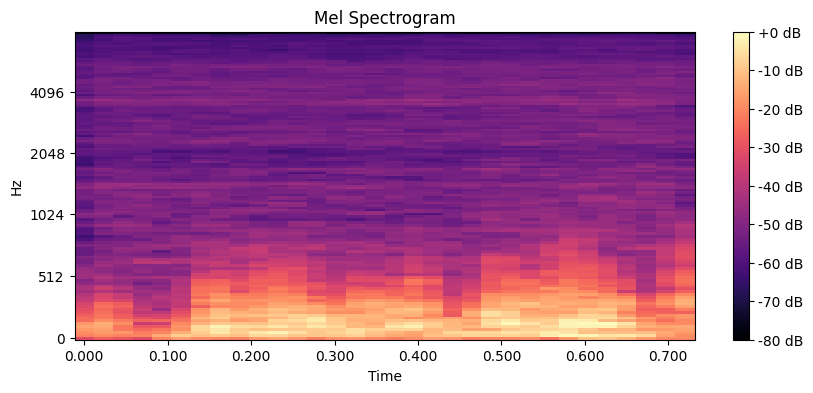

In [ ]:
# Load audio
file_path = '/content/record_to_1_sec/bad/segment_10.wav'
audio = load_audio(file_path)

# Create spectrogram
spectrogram = create_spectrogram(audio)

# Plot spectrogram (optional)
plot_spectrogram(spectrogram)

# Normalize spectrogram (optional but recommended)
normalized_spectrogram = (spectrogram - np.mean(spectrogram)) / np.std(spectrogram)


### Create the dataset

- Get the labels from the csv
- Convert each wav file to a spectogram
- Save the spectograms at a list (X) that represents the featurs
- Save the labels at a list (Y) that represents the labels
- Split the data to train and test

In [ ]:
!pip install tensorflow

In [6]:
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

# Load CSV file with file names and labels
csv_file_path = '/content/label/labels.csv'
data_df = pd.read_csv(csv_file_path)

# Define a function to load audio and create spectrogram
def load_audio_and_spectrogram(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    spectrogram = np.abs(librosa.stft(audio))
    return spectrogram

# Define function to preprocess spectrogram
def preprocess_spectrogram(spectrogram):
    # Normalize spectrogram
    normalized_spectrogram = (spectrogram - np.mean(spectrogram)) / np.std(spectrogram)
    # Resize spectrogram to a fixed shape (if needed)
    # normalized_spectrogram = resize(normalized_spectrogram, target_shape)
    return normalized_spectrogram

# Prepare data and labels for the CNN
X = []  # List to store spectrogram data
y = []  # List to store labels

for index, row in data_df.iterrows():
    file_name = row['filename']  # Update with CSV column name for file names
    label = row['label']  # Update with CSV column name for labels
    if label == 1:
        file_path = '/content/record_to_1_sec/good/' + file_name  # Update with audio files directory for 'good' files
    elif label == 0:
        file_path = '/content/record_to_1_sec/bad/' + file_name  # Update with audio files directory for 'bad' files
    else:
        # Handle other cases or raise an error
        continue  # Skip this iteration if label is neither '1' nor '0'

    # Load audio and create spectrogram
    spectrogram = load_audio_and_spectrogram(file_path)

    # Preprocess spectrogram
    processed_spectrogram = preprocess_spectrogram(spectrogram)

    # Append to data and labels lists
    X.append(processed_spectrogram)
    y.append(label)

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Optionally, convert labels to categorical if needed (e.g., for multi-class classification)
# y = to_categorical(y)

# Shuffle and split the dataset into train and test sets (or use other methods for splitting)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Split the training data into training and validation sets
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Print shapes for verification
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5875, 1025, 94)
X_val shape: (327, 1025, 94)
X_test shape: (326, 1025, 94)
y_train shape: (5875,)
y_val shape: (327,)
y_test shape: (326,)


### Make the data dirty
- Dirt for spectogram


In [10]:
# Add salt and pepper noise to 50% of the training data
def add_salt_pepper_noise(spectrogram, salt_prob=0.05, pepper_prob=0.05):
    noisy_spectrogram = np.copy(spectrogram)
    salt = np.random.rand(*noisy_spectrogram.shape) < salt_prob
    pepper = np.random.rand(*noisy_spectrogram.shape) < pepper_prob

    # Add salt noise (set to maximum value)
    noisy_spectrogram[salt] = np.max(noisy_spectrogram)

    # Add pepper noise (set to minimum value)
    noisy_spectrogram[pepper] = np.min(noisy_spectrogram)

    return noisy_spectrogram

def add_gaussian_noise(spectrogram, mean=0, std=0.1):
    noisy_spectrogram = spectrogram + np.random.normal(mean, std, spectrogram.shape)
    return noisy_spectrogram

def add_speckle_noise(spectrogram, mean=0, std=0.1):
    noise = np.random.normal(mean, std, spectrogram.shape)
    noisy_spectrogram = spectrogram + spectrogram * noise
    return noisy_spectrogram

def add_uniform_noise(spectrogram, min_val=0, max_val=0.1):
    noisy_spectrogram = spectrogram + np.random.uniform(min_val, max_val, spectrogram.shape)
    return noisy_spectrogram

# Define the noise functions and their probabilities
noise_functions = [
    add_salt_pepper_noise,
    add_gaussian_noise,
    add_speckle_noise,
    add_uniform_noise,
]
noise_probs = [0.25, 0.25, 0.25, 0.25]  # Equal probabilities for each noise function

# Apply noise to 50% of the training data randomly
for i in range(len(X_train)):
    if np.random.rand() < 0.5:  # Apply noise with 50% probability
        noise_func = np.random.choice(noise_functions, p=noise_probs)
        X_train[i] = noise_func(X_train[i])

### The Model

In [11]:
from torch import nn
import torch

DROP_OUT = 0.5
DIMENSION = 512 * 300


class Convolutional_Speaker_Identification(nn.Module):

    def cal_paddind_shape(self, new_shape, old_shape, kernel_size, stride_size):
        return (stride_size * (new_shape - 1) + kernel_size - old_shape) / 2

    def __init__(self, num_speakers):

        super().__init__()
        self.num_speakers = num_speakers

        self.conv_2d_1 = nn.Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2), padding=1)
        self.bn_1 = nn.BatchNorm2d(96)
        self.max_pool_2d_1 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2))

        self.conv_2d_2 = nn.Conv2d(96, 256, kernel_size=(5, 5), stride=(2, 2), padding=1)
        self.bn_2 = nn.BatchNorm2d(256)
        self.max_pool_2d_2 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2))

        self.conv_2d_3 = nn.Conv2d(256, 384, kernel_size=(3, 3), padding=1)
        self.bn_3 = nn.BatchNorm2d(384)

        self.conv_2d_4 = nn.Conv2d(384, 256, kernel_size=(3, 3), padding=1)
        self.bn_4 = nn.BatchNorm2d(256)

        self.conv_2d_5 = nn.Conv2d(256, 256, kernel_size=(3, 3), padding=1)
        self.bn_5 = nn.BatchNorm2d(256)
        self.max_pool_2d_3 = nn.MaxPool2d(kernel_size=(5, 3), stride=(3, 2))

        self.conv_2d_6 = nn.Conv2d(256, 4096, kernel_size=(9, 1), padding=0)
        self.drop_1 = nn.Dropout(p=DROP_OUT)

        self.global_avg_pooling_2d = nn.AdaptiveAvgPool2d((1, 1))
        self.dense_1 = nn.Linear(4096, 1024)
        self.drop_2 = nn.Dropout(p=DROP_OUT)

        self.dense_2 = nn.Linear(1024, self.num_speakers)

    def forward(self, X):

        x = nn.ReLU()(self.conv_2d_1(X))
        x = self.bn_1(x)
        x = self.max_pool_2d_1(x)

        x = nn.ReLU()(self.conv_2d_2(x))
        x = self.bn_2(x)
        x = self.max_pool_2d_2(x)

        x = nn.ReLU()(self.conv_2d_3(x))
        x = self.bn_3(x)

        x = nn.ReLU()(self.conv_2d_4(x))
        x = self.bn_4(x)

        x = nn.ReLU()(self.conv_2d_5(x))
        x = self.bn_5(x)
        x = self.max_pool_2d_3(x)

        x = nn.ReLU()(self.conv_2d_6(x))
        x = self.drop_1(x)
        x = self.global_avg_pooling_2d(x)

        x = x.view(-1, x.shape[1])  # output channel for flatten before entering the dense layer
        x = nn.ReLU()(self.dense_1(x))
        x = self.drop_2(x)

        x = self.dense_2(x)
        y = nn.LogSoftmax(dim=1)(x)   # consider using Log-Softmax

        return y

    def get_epochs(self):
        return 3

    def get_learning_rate(self):
        return 0.0001

    def get_batch_size(self):
        return 16

    def to_string(self):
        return "Convolutional_Speaker_Identification_Log_Softmax_Model-epoch_"

### Train the model
- get accuracy and loss

Epoch [1/3], Train Loss: 0.1645, Train Accuracy: 0.9217, Val Loss: 0.0548, Val Accuracy: 0.9908
Epoch [2/3], Train Loss: 0.0154, Train Accuracy: 0.9944, Val Loss: 0.0001, Val Accuracy: 1.0000
Epoch [3/3], Train Loss: 0.0003, Train Accuracy: 1.0000, Val Loss: 0.0014, Val Accuracy: 1.0000


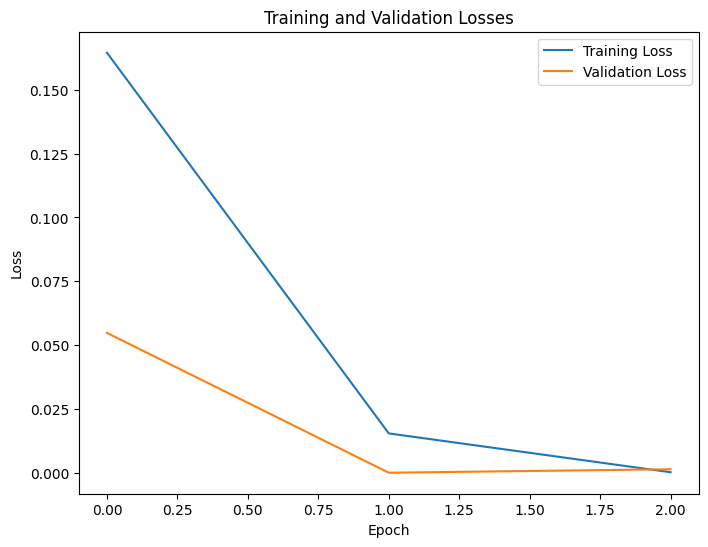

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define your CNN model
num_speakers = 2
model = Convolutional_Speaker_Identification(num_speakers)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=model.get_learning_rate())

# Convert data to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).unsqueeze(1).float()  # Add channel dimension for 1-channel spectrograms
y_train_tensor = torch.from_numpy(y_train).long()  # Convert labels to long tensor
X_val_tensor = torch.from_numpy(X_val).unsqueeze(1).float()  # Convert validation data to PyTorch tensors
y_val_tensor = torch.from_numpy(y_val).long()

# Define lists to store training and validation losses
train_losses = []
val_losses = []

# Create a DataLoader for training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=model.get_batch_size(), shuffle=True)

# Convert validation data to PyTorch tensors and create DataLoader for validation set
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=model.get_batch_size(), shuffle=False)  # No need to shuffle during validation

# Training loop
num_epochs = model.get_epochs()
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    predictions = []
    true_labels = []
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the gradients

        outputs = model.forward(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()

        # Convert logits to probabilities and get predicted labels
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    accuracy = accuracy_score(true_labels, predictions)

    # Evaluate on validation set
    model.eval()  # Set model to evaluation mode
    val_running_loss = 0.0
    val_predictions = []
    val_true_labels = []
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_outputs = model.forward(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()

            # Convert logits to probabilities and get predicted labels
            _, val_predicted = torch.max(val_outputs, 1)
            val_predictions.extend(val_predicted.tolist())
            val_true_labels.extend(val_labels.tolist())

    val_epoch_loss = val_running_loss / len(val_loader)
    val_losses.append(val_epoch_loss)
    val_accuracy = accuracy_score(val_true_labels, val_predictions)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')


# Plotting the training and validation losses
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Save the model if needed
torch.save(model.state_dict(), '/model')


### Test the model

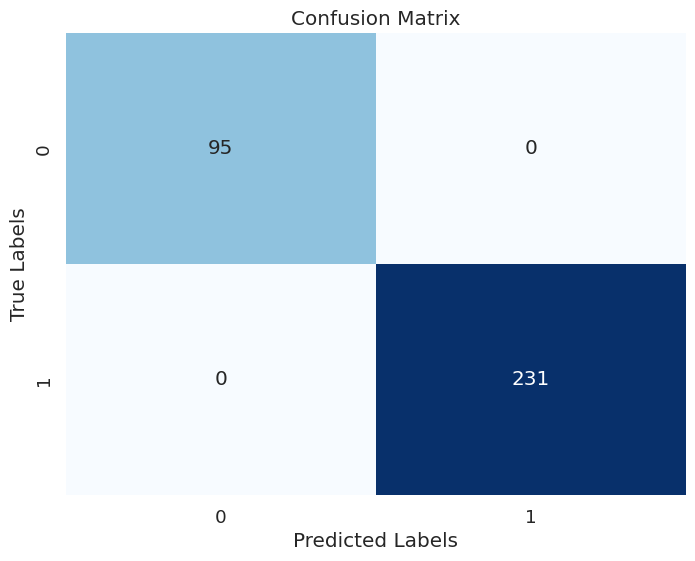

Test Loss: 0.001479011522252484


In [13]:
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix

def test_model_and_get_confusion_matrix(model, X_test, y_test, criterion, batch_size, shuffle=False):
    device = torch.device("cpu")

    # Convert NumPy arrays to PyTorch tensors
    X_test_tensor = torch.from_numpy(X_test).unsqueeze(1).float()
    y_test_tensor = torch.from_numpy(y_test)

    # Create TensorDataset and DataLoader for test set
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

    model.eval()
    all_preds = []
    all_labels = []
    test_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    confusion_mat = confusion_matrix(all_labels, all_preds)

    return confusion_mat, test_loss

# Example usage
confusion_mat, test_loss = test_model_and_get_confusion_matrix(model, X_test, y_test, criterion, model.get_batch_size())

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("Test Loss:", test_loss)

### Try the model on example

In [ ]:
import torchaudio

wav_path = 'path_to_your_wav_file.wav'
waveform, sample_rate = torchaudio.load(wav_path)

In [ ]:
# Convert audio to spectrogram
mel_spec_transform = torchaudio.transforms.MelSpectrogram()
mel_spec = mel_spec_transform(waveform)

# Resize the spectrogram to match the expected input shape
resized_spec = torch.nn.functional.interpolate(mel_spec, size=(height, width))

# Add batch dimension
input_data = resized_spec.unsqueeze(0)  # Add batch dimension

In [ ]:
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculation during inference
    output = model(input_data)

# Convert output to probabilities
probabilities = torch.exp(output)

In [ ]:
predicted_speaker = torch.argmax(probabilities, dim=1).item()